# Training a multi-task regression model for neural crest cells

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata

## Set experiment parameters

In [3]:
experiment = 'multi_task_1'
if not os.path.exists(experiment):
    os.makedirs(experiment)
    
genome = 'danRer11' #"GRCz11"
seq_len = 200 # Length of the input sequence

## Load Data

In [4]:
peaks = pd.read_csv("../data/normalized_peaks.csv")

ad = peaks.to_numpy()
ad = anndata.AnnData(ad).T

# Prepare ad.obs
cell_types = pd.DataFrame({'cell type': peaks.columns})
ad.obs = cell_types
ad.obs_names = ad.obs['cell type']

# Prepare ad.var
var = pd.read_csv("../data/chromosomes.10hpf.bed", sep = '\t', header = None)
var.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
var = var.drop(columns =['name', 'score', 'strand'])
var.index = var.index.astype(str)
ad.var = var

ad.shape

(15, 370058)

In [5]:
ad.obs

,cell type
cell type,
anterior/posterior axis,anterior/posterior axis
central nervous system,central nervous system
forebrain,forebrain
immature eye,immature eye
integument,integument
lateral plate mesoderm,lateral plate mesoderm
mesenchyme cell,mesenchyme cell
musculature system,musculature system
neural crest,neural crest


In [6]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

In [7]:
ad.var.head()

,chrom,start,end
0,chr1,5231,5732
1,chr1,5786,6287
2,chr1,10087,10588
3,chr1,10990,11491
4,chr1,11894,12395


In [8]:
ad.X[0:5,0:5]

array([[4.65111754, 4.7597768 , 4.84433467, 4.91311991, 5.09123001],
       [4.53367234, 4.71507734, 4.6939733 , 4.97038916, 5.15560569],
       [3.74337616, 3.89092058, 3.71531718, 4.50199984, 4.58080749],
       [4.67651185, 4.80295157, 4.32103392, 4.53860808, 4.89682671],
       [3.88919404, 3.75913911, 3.88919404, 4.40643606, 4.7314921 ]])

## Select small dataset for testing

In [9]:
ad = ad[:,:50000]
ad.shape

(15, 50000)

## Filter peaks

Performing filtering of the dataset using `grelu.data.preprocess` module.

First, we filter peaks within autosomes (chromosomes 1 - 22) or chromosomes X/Y.

In [10]:
import grelu.data.preprocess

ad = grelu.data.preprocess.filter_chromosomes(ad, 'autosomes')

Keeping 50000 intervals


## Resize peaks

ATAC-seq peaks can take different lengths. Hence, we resize all ATAC-seq peaks to a constant sequence length of 200 bp to train the model as follows:

In [11]:
import grelu.sequence.utils


ad.var = grelu.sequence.utils.resize(ad.var, seq_len)
ad.var.head(3)

,chrom,start,end
0,chr1,5382,5582
1,chr1,5937,6137
2,chr1,10238,10438


## Split data

In [12]:
ad.var['chrom'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4'], dtype=object)

In [13]:
train_chroms='autosomes'
val_chroms=['chr3']
test_chroms=['chr4']


ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad, 
    train_chroms = train_chroms, val_chroms = val_chroms, 
    test_chroms = test_chroms,
)

Selecting training samples
Keeping 32368 intervals


Selecting validation samples
Keeping 17079 intervals


Selecting test samples
Keeping 553 intervals
Final sizes: train: (15, 32368), val: (15, 17079), test: (15, 553)


## Make labeled sequence datasets

In [14]:
import grelu.data.dataset

In [15]:
train_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_train.copy(),
    genome = genome,
    rc = True, #reverse complement
    max_seq_shift = 1, # Shift the sequence
    augment_mode = "random", # Randomly select which augmentations to apply
)

In [16]:
val_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_val.copy(), genome=genome)
test_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_test.copy(), genome=genome)

## Build model

Here we use the DiltatedConvModel

In [17]:
model_params = {
    'model_type':'DilatedConvModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, # No cropping of the model output. What does this really mean?
    'channels':512,
    'n_conv':8,
}

train_params = {
    'task':'regression', # regression
    'loss': 'mse', 
    'lr': 1e-4, # learning rate
    'logger': 'csv', # Logs will be written to a CSV file
    'batch_size':512,
    'max_epochs':10,
    'devices':0, # Either “cpu” or an integer or list of integers representing the indices of the GPUs for training
    'num_workers':8,
    'optimizer': 'adam',
    'save_dir':experiment,
    'checkpoint': True, # Save checkpoints
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params, train_params)

## Train model

In [18]:
# See the 'single_task_1' folder for logs
trainer = model.train_on_dataset(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss              7.5404052734375
         val_mse             7.466798782348633
       val_pearson                  nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | DilatedConvModel | 5.6 M  | train
1 | loss         | MSELoss          | 0      | train
2 | activation   | Identity         | 0      | train
3 | val_metrics  | MetricCollection | 0      | train
4 | test_metrics | MetricCollection | 0      | train
5 | transform    | Identity         | 0      | train
----------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.239    Total estimated model params size (MB)
119       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Load best model from checkpoint

In [19]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

multi_task_1/2025_01_04_23_11/version_0/checkpoints/epoch=8-step=576.ckpt


## Evaluate model on the test set

In [20]:
test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=256,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.14989173412323
        test_mse            1.2708117961883545
      test_pearson          0.27944356203079224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Run inference on held out sequences

In [155]:
preds = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8
    )
preds.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

(553, 15, 1)

In [22]:
import grelu.visualize

/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/grelu/visualize.py:191: UserWarning: Currently density plot cannot be faceted due to plotnine issues. All tasks will be combined.


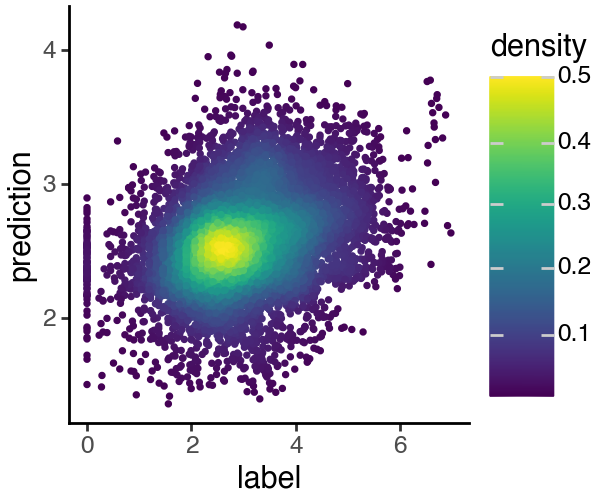

In [23]:
grelu.visualize.plot_pred_scatter(
    preds=preds,
    labels=test_dataset.get_labels(),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotnine as p9


for i in range(len(ad_test.obs['cell type'])):
    obs_copy = ad_test.obs.copy()
    cell_type = obs_copy['cell type'].str.replace(r'[/ ]', '_', regex=True).iloc[i]  # Fix: Use iloc for positional indexing

    
    # Assign the plot to a variable
    plot = (
        grelu.visualize.plot_pred_scatter(
            preds=preds,
            labels=test_dataset.get_labels(),
            density=True,
            tasks=[i],
            figsize=(3, 2.5),
            size=0.5
        )
        + p9.labs(title=cell_type)  # Add title
    )
    
    plot.draw()  # Explicitly render the plot
    plt.show()   # Display the plot

    # Save plot to file if display fails
    plot.save(f"../results/corr_plot_multi_task_50k_{cell_type}.png", dpi=300)


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2.5 in image.
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../results/corr_plot_multi_task_50k_anterior_posterior_axis.png
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2.5 in image.
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../results/corr_plot_multi_task_50k_central_nervous_system.png
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2.5 in image.
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../results/corr_plot_multi_task_50k_forebrain.png
/Users/victoremenike/anacond

In [185]:
from torchmetrics.regression import PearsonCorrCoef
import torch 

preds_2d = preds.squeeze(-1)  # [batch_size * seq_len, num_tasks]
preds_2d = torch.from_numpy(preds_2d)
target_2d = test_dataset.get_labels().squeeze(-1)
target_2d = torch.from_numpy(target_2d)

coeff = PearsonCorrCoef(num_outputs=15)
coeff.update(preds_2d, target_2d)

# Compute result
result = coeff.compute()
print(result)


tensor([0.2990, 0.3258, 0.2218, 0.2513, 0.2763, 0.3392, 0.3037, 0.2501, 0.3099,
        0.3412, 0.2697, 0.2353, 0.2569, 0.3164, 0.1950])


In [192]:
corr_cells = pd.DataFrame({'cell_type': ad_test.obs['cell type'], 
                          'pearson correlation': result} )
corr_cells = corr_cells.reset_index().drop(columns= 'cell_type')

corr_cells.to_csv('../results/cell_type_pearson_corr.csv', index=False)

## Viewing model importance on neural crest using sequence attributes

In [24]:
for key in list(model.data_params.keys())[:21]:
    if key !="tasks":
        print(key, model.data_params[key])

train {'bin_size': 1, 'end': 'both', 'genome': 'danRer11', 'intervals': {'chrom': ['chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1', 'chr1

In [25]:
tasks = pd.DataFrame(model.data_params['tasks'])
tasks.head()

,name,cell type
0,anterior/posterior axis,anterior/posterior axis
1,central nervous system,central nervous system
2,forebrain,forebrain
3,immature eye,immature eye
4,integument,integument


In [26]:
import grelu.sequence.utils
start_seq = grelu.sequence.utils.generate_random_sequences(
    n=1, # number of sequences to generate
    seq_len= seq_len, # Length of the generated sequence
    seed=0,
    output_format="strings"
)[0]
start_seq

'ATCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTCTTGTACCCTATGATTGTGTAGAAACCGAACTACGGTACCTCCTGTTGGTAGTCACGATAGATTATAAAAGTATGTTCCCACCCTATCGACGAGACTGGCATCCTAGGTGTTTGCGGTGTTGGTACGTGCGCAGGTATGTAAGAGTGGTAAACGA'

In [27]:
from grelu.transforms.prediction_transforms import Aggregate

neural_crest_score = Aggregate(
    tasks = ["neural crest"],
    model = model,
)

In [28]:
import grelu.design

output = grelu.design.evolve(
    [start_seq], # The initial sequences
    model, 
    prediction_transform=neural_crest_score, # Objective to optimize 
    max_iter=5, # Number of iterations for directed evolution
    num_workers=8,
    devices=0,
    return_seqs="all", # Return all the evolved sequences
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Iteration 0


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best value at iteration 0: 2.362
Iteration 1


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best value at iteration 1: 2.416
Iteration 2


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best value at iteration 2: 2.473
Iteration 3


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best value at iteration 3: 2.523
Iteration 4


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best value at iteration 4: 2.573
Iteration 5


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best value at iteration 5: 2.623


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [29]:
output.head()

,iter,start_seq,best_in_iter,prediction_score,seq_score,total_score,seq,position,allele,neural crest
0,0,0,True,2.361964,0,2.361964,ATCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,NaN,NaN,2.361964
1,1,0,False,2.373503,0,2.373503,CTCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,0.0,C,2.373503
2,1,0,False,2.371631,0,2.371631,GTCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,0.0,G,2.371631
3,1,0,False,2.363720,0,2.363720,TTCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,0.0,T,2.363720
4,1,0,False,2.360179,0,2.360179,AACATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,1.0,A,2.360179


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/plotnine/themes/themeable.py:2438: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


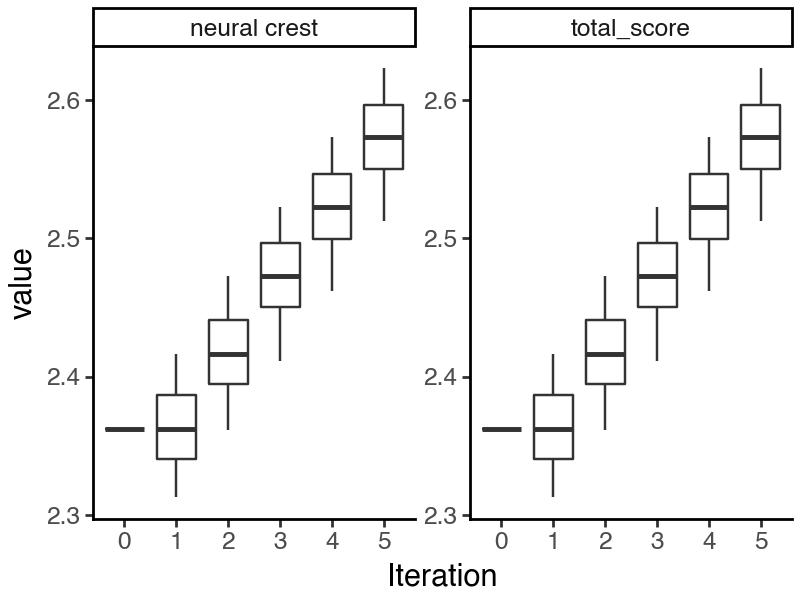

In [30]:
import grelu.visualize
grelu.visualize.plot_evolution(output, outlier_size=.1)

In [31]:
end_seq = output[output.iter==5].sort_values('total_score').iloc[-1].seq
end_seq

'ATCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTCTTGTACCCTATGATTGTGTAGAAACCGAACTACGGTACCTCCTGTTGGTAGTCACGATAGATTATAAAAGTATGTTCCCACCCTCTCGCCGAGACTGGCAGCCTCGGTGTGTGCGGTGTTGGTACGTGCGCAGGTATGTAAGAGTGGTAAACGA'

In [32]:
import grelu.sequence.mutate
mutated_positions = grelu.sequence.mutate.seq_differences(start_seq, end_seq, verbose=True)

Position: 130 Reference base: A Alternate base: C Reference sequence: ACCCTATCGA
Position: 134 Reference base: A Alternate base: C Reference sequence: TATCGACGAG
Position: 146 Reference base: T Alternate base: G Reference sequence: TGGCATCCTA
Position: 150 Reference base: A Alternate base: C Reference sequence: ATCCTAGGTG
Position: 156 Reference base: T Alternate base: G Reference sequence: GGTGTTTGCG


In [33]:
import grelu.interpret.score

start_attrs = grelu.interpret.score.get_attributions(
    model, start_seq, prediction_transform=neural_crest_score, device=0,
    method="inputxgradient",
)
end_attrs = grelu.interpret.score.get_attributions(
    model, end_seq, prediction_transform=neural_crest_score, device=0,
    method="inputxgradient",
)

/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


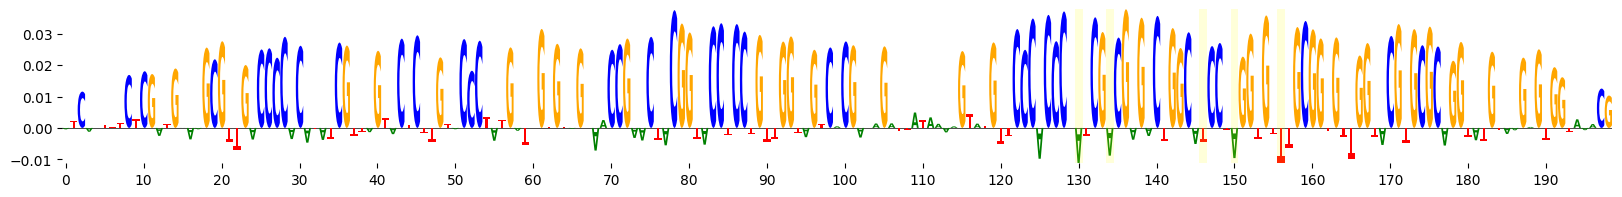

In [34]:
grelu.visualize.plot_attributions(
    start_attrs, 
    highlight_positions=mutated_positions, # Highlight the mutated positions
    ticks=10,
)

plt.show()

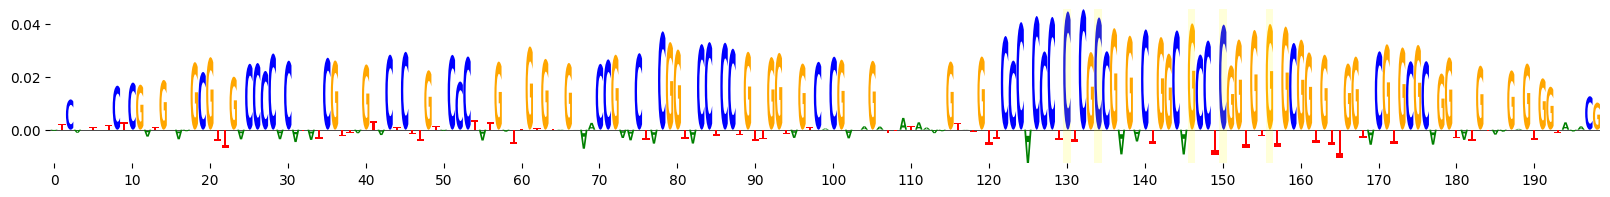

In [35]:
grelu.visualize.plot_attributions(
    end_attrs,
    highlight_positions=mutated_positions, # Highlight the mutated positions,
    ticks=10,
)

plt.show()

## Correlations for each cell type in test set

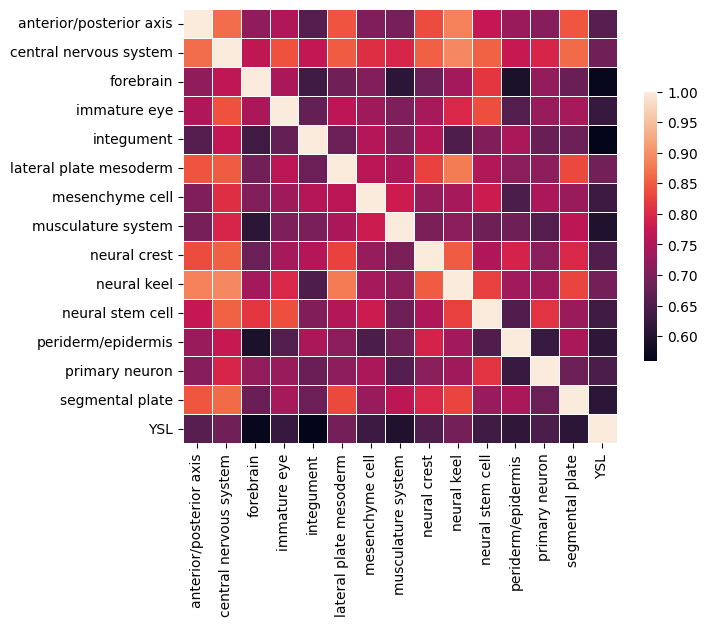

In [66]:
import seaborn as sns


# Compute the correlation matrix
corr = peaks_test_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()